In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
# from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import datetime

Using TensorFlow backend.
C:\Users\jsson\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\jsson\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\jsson\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\jsson\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

# Load Dataset

In [14]:
data = pd.read_csv('kohyoung.csv')
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-12,44950.0,46950.0,44950.0,46200.0,46200.0,57188.0
1,2015-01-13,46050.0,46400.0,45000.0,45800.0,45800.0,41779.0
2,2015-01-14,45000.0,45500.0,44250.0,45050.0,45050.0,63993.0
3,2015-01-15,45050.0,45150.0,44250.0,45050.0,45050.0,18964.0
4,2015-01-16,45100.0,45600.0,44050.0,44850.0,44850.0,27595.0
...,...,...,...,...,...,...,...
748,2018-01-26,90000.0,92000.0,89200.0,91100.0,91100.0,94872.0
749,2018-01-29,92300.0,94200.0,91100.0,92400.0,92400.0,98486.0
750,2018-01-30,91400.0,96000.0,89500.0,94900.0,94900.0,165570.0
751,2018-01-31,95800.0,95800.0,93100.0,94100.0,94100.0,86418.0


In [3]:
data.isnull().sum()

Date         0
Open         3
High         3
Low          3
Close        3
Adj Close    3
Volume       3
dtype: int64

In [4]:
data.dropna(inplace=True)

In [5]:
data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

# Compute Mid Price

In [6]:
high_prices = data['High'].values
low_prices = data['Low'].values
mid_prices = (high_prices + low_prices) / 2

# Create Windows

In [7]:
seq_len = 60
sequence_length = seq_len + 1

result = []
for index in range(len(mid_prices) - sequence_length):
    result.append(mid_prices[index: index + sequence_length])

In [8]:
normalized_data = []
for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data)

# split train and test data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((620, 60, 1), (69, 60, 1))

# Build a Model

In [9]:
model = Sequential()

model.add(LSTM(60, return_sequences=True, input_shape=(60, 1)))

model.add(LSTM(64, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='rmsprop')

model.summary()





_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 60)            14880     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                32000     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 46,945
Trainable params: 46,945
Non-trainable params: 0
_________________________________________________________________


# Training

In [10]:
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=20)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 620 samples, validate on 69 samples
Epoch 1/20
620/620 [==============================] - 12s 20ms/step - loss: 0.0021 - val_loss: 0.0066
Epoch 2/20
620/620 [==============================] - 10s 16ms/step - loss: 0.0011 - val_loss: 0.0029
Epoch 3/20
620/620 [==============================] - 10s 16ms/step - loss: 8.8923e-04 - val_loss: 0.0023
Epoch 4/20
620/620 [==============================] - 10s 16ms/step - loss: 7.8343e-04 - val_loss: 0.0018
Epoch 5/20
620/620 [==============================] - 10s 16ms/step - loss: 6.4641e-04 - val_loss: 0.0023
Epoch 6/20
620/620 [==============================] - 10s 16ms/step - loss: 5.6231e-04 - val_loss: 0.0012
Epoch 7/20
620/620 [==============================] - 10s 16ms/step - loss: 5.0689e-04 - val_loss: 9.8603e-04
Epoch 8/20
620/620 [==============================] - 10s 16ms/step - loss: 4.3052e-04 - val_loss: 8.0189e-04
Epoch 9/20


# Prediction

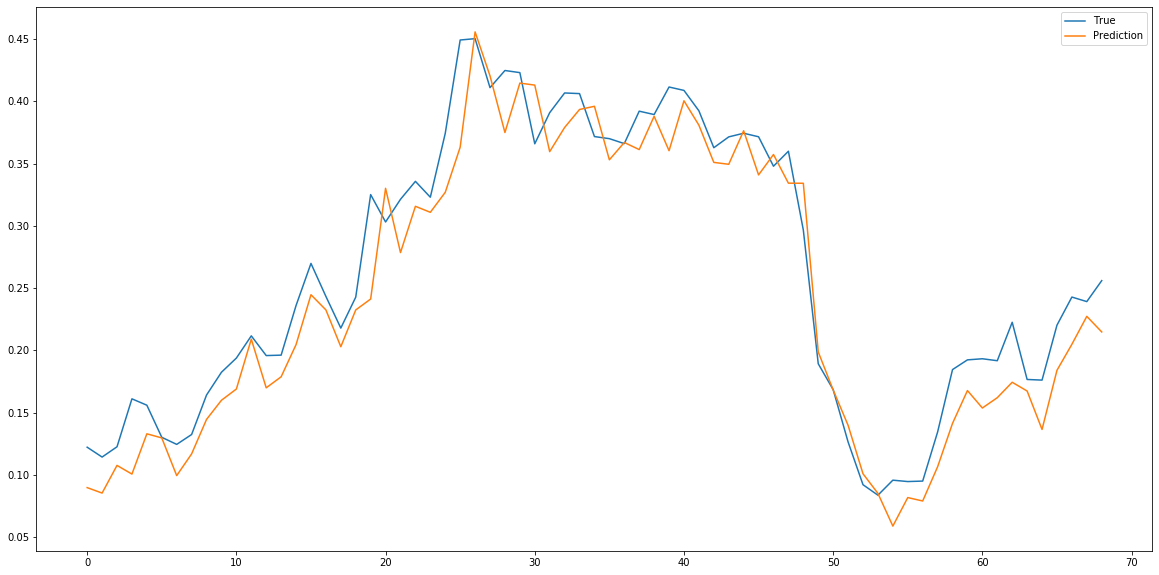

In [11]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()